# Targeting Direct Marketing with Random Forest at Local
_**Supervised Learning with Random Forest: A Binary Prediction Problem With Unbalanced Classes**_

This notebook works well with the `Python 3 (Data Science)` kernel on SageMaker Studio.

---

---

## Contents

1. [Overview](#Overview)
1. [Preperation](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Overview
In this workshop, you will learn how to use Amazon SageMaker Managed Notebook environment - <b>SageMaker Studio</b> to build, train and deploy a machine learning (ML) model using SKLearn framework.   

In this exercise, you have been asked to to develop a machine learning model to predict whether a customer will enroll for a certificate of deposit (CD), after the customer has been contacted through mail, email, phone, etc.  The model will be trained on the marketing dataset that contains information on customer demographics, responses to marketing events, and environmental factors. Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  

The data has been labeled for your convenience and a column in the dataset identifies whether the customer is enrolled for a product offered by the bank. A version of this dataset is publicly available  from the ML repository curated by the University of California, Irvine (https://archive.ics.uci.edu/ml/datasets/bank+marketing). This tutorial implements a supervised machine learning model, since the data is labeled. (Unsupervised learning occurs when the datasets are not labeled.)

The steps include:

* Downloading training data into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Fitting a model using Random Forest Classifier
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

## Feature Engineering
In this part of the tutorial, you will learn about the highlighted part of machine learning process:
![png](./image/ML-pipeline.JPG)

---

## Data

In this step you will use your Amazon SageMaker Studio notebook to preprocess the data that you need to train your machine learning model.



Execute each cell by pressing <b> Shift+Enter </b> in each of the cells. While the code runs, an * appears between the square brackets as pictured in the first screenshot to the right. After a few seconds, the code execution will complete, the * will be replaced with the number 1.



Let's start by:

- Upgrading Pandas (Python library for scientific computing) to the latest version
- Specifying the S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- Specifying the IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
- Importing the necessary Python libraries that we will use throughout the analysis and define a few environment variables in your Jupyter environment.

In [2]:
# cell 01 - upgrade Pandas to the latest version
!pip install -qU pandas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json
from IPython.display import display

import boto3 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

Make sure pandas version is set to 1.2.4 or later. If it is not the case, restart the kernel before going further

---

## Downloading data
Download the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket by running the 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


In [5]:
# cell 05
# restore the shared variables
%store -r bucket
%store -r prefix
%store -r data_folder
%store -r data_file_path

In the next cell, you will load the dataset into a pandas dataframe.

In [6]:
# cell 06
data = pd.read_csv(data_file_path)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Exploration
7. Let's start exploring the data.  First, let's understand how the features are distributed.

col_0,% observations
job,
admin.,0.253035
blue-collar,0.224677
entrepreneur,0.035350
housemaid,0.025736
management,0.070992
retired,0.041760
self-employed,0.034500
services,0.096363
student,0.021244


col_0,% observations
marital,
divorced,0.111974
married,0.605225
single,0.280859
unknown,0.001942


col_0,% observations
education,
basic.4y,0.101389
basic.6y,0.055647
basic.9y,0.146766
high.school,0.231014
illiterate,0.000437
professional.course,0.127294
university.degree,0.295426
unknown,0.042027


col_0,% observations
default,
no,0.791201
unknown,0.208726
yes,0.000073


col_0,% observations
housing,
no,0.452122
unknown,0.024036
yes,0.523842


col_0,% observations
loan,
no,0.824269
unknown,0.024036
yes,0.151695


col_0,% observations
contact,
cellular,0.634748
telephone,0.365252


col_0,% observations
month,
apr,0.063902
aug,0.149995
dec,0.004419
jul,0.174177
jun,0.129115
mar,0.013256
may,0.334296
nov,0.099568
oct,0.017432


col_0,% observations
day_of_week,
fri,0.190031
mon,0.206711
thu,0.209357
tue,0.196416
wed,0.197485


col_0,% observations
poutcome,
failure,0.103234
nonexistent,0.863431
success,0.033335


col_0,% observations
y,
no,0.887346
yes,0.112654


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


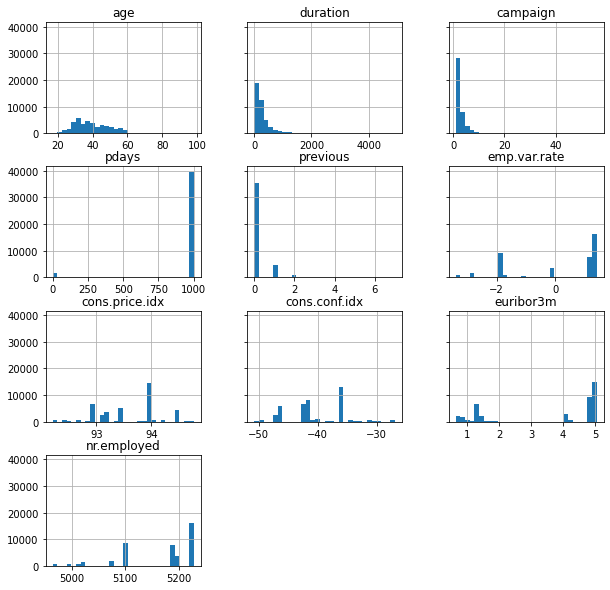

In [7]:
# cell 07
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

Notice that:

* Almost 90% of the values for our target variable `y` are "no", so most customers did not subscribe to a term deposit.
* Many of the predictive features take on values of `unknown`.  Some are more common than others.  We should think carefully as to what causes a value of "unknown" (are these customers non-representative in some way?) and how we that should be handled.
  * Even if `unknown` is included as it's own distinct category, what does it mean given that, in reality, those observations likely fall within one of the other categories of that feature?
* Many of the predictive features have categories with very few observations in them.  If we find a small category to be highly predictive of our target outcome, do we have enough evidence to make a generalization about that?
* Contact timing is particularly skewed.  Almost a third in May and less than 1% in December.  What does this mean for predicting our target variable next December?
* There are no missing values in our numeric features.  Or missing values have already been imputed.
  * `pdays` takes a value near 1000 for almost all customers.  Likely a placeholder value signifying no previous contact.
* Several numeric features have a very long tail.  Do we need to handle these few observations with extremely large values differently?
* Several numeric features (particularly the macroeconomic ones) occur in distinct buckets.  Should these be treated as categorical?



Next, let's look at how our features relate to the target that we are attempting to predict.

y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


age


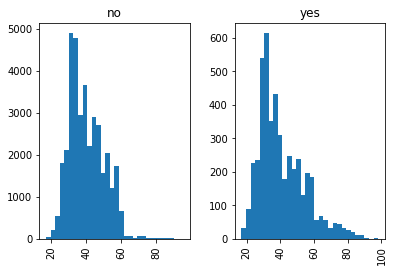

duration


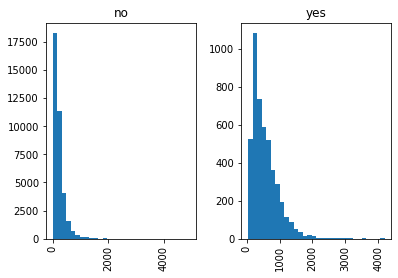

campaign


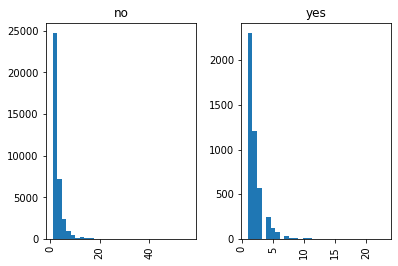

pdays


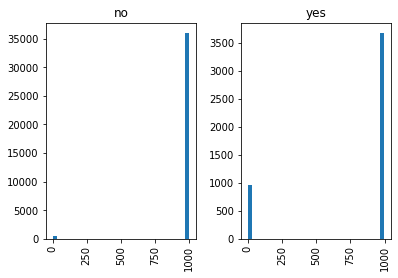

previous


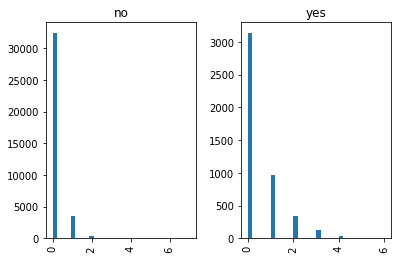

emp.var.rate


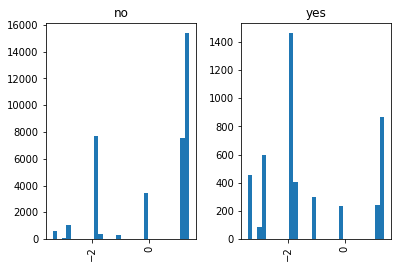

cons.price.idx


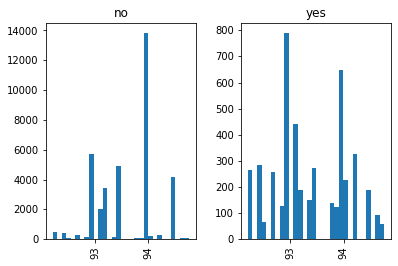

cons.conf.idx


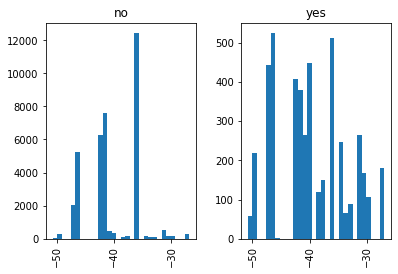

euribor3m


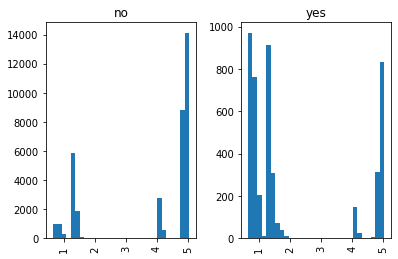

nr.employed


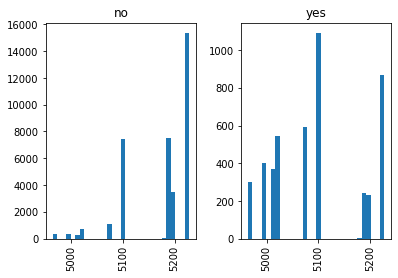

In [8]:
# cell 08
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

Notice that:

* Customers who are-- blue-collar", "married", "unknown" default status, contacted by "telephone", and/or in "may" are a substantially lower portion of "yes" than "no" for subscribing.
* Distributions for numeric variables are different across "yes" and "no" subscribing groups, but the relationships may not be straightforward or obvious.



9. Now let's look at how our features relate to one another.

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


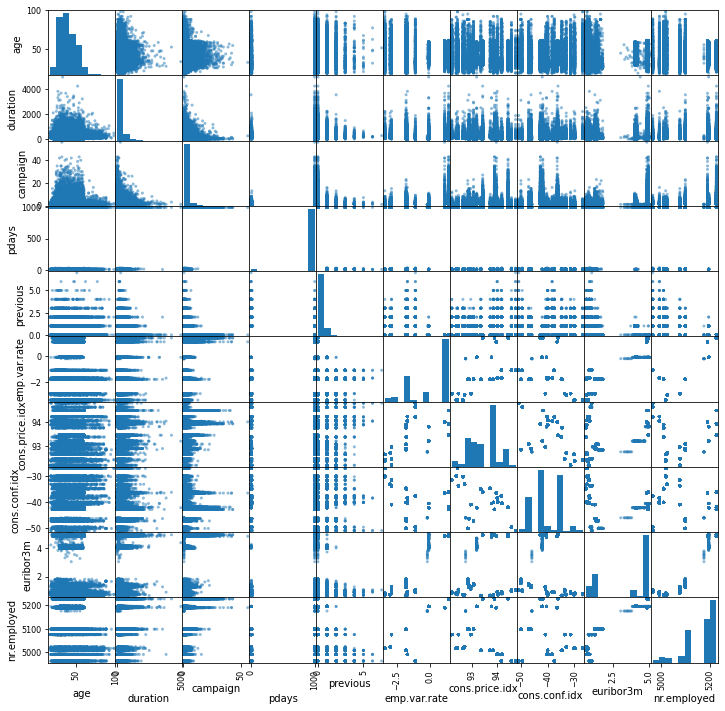

In [9]:
# cell 09 -- using a correlation matrix and scatter matrix understand how features are related to one another
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

Notice that:
* Features vary widely in their relationship with one another.  Some with highly negative correlation, others with highly positive correlation.
* Relationships between features is non-linear and discrete in many cases.

### Transformation

Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* <b>Handling missing values:</b> Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * <b>Removing observations with missing values:</b> This works well if only a very small fraction of observations have incomplete information.
 * <b>Removing features with missing values</b>: This works well if there are a small number of features which have a large number of missing values.
 * <b>Imputing missing values</b>: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* <b>Converting categorical to numeric</b>: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* <b>Oddly distributed data</b>: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains is left for other notebook templates.

Luckily, some of these aspects have already been handled for us, and the algorithm we are showcasing tends to do well at handling sparse or oddly distributed data.  Therefore, let's keep pre-processing simple.

To summarise, we need to A) address some weird values, B) convert the categorical to numeric valriables and C) Remove unnecessary data:

* Many records have the value of "999" for pdays. It is very likely to be a 'magic' number to represent that no contact was made before. Considering that, we will create a new column called "no_previous_contact", then grant it value of "1" when pdays is 999 and "0" otherwise.
* In the job column, there are more than one categories for people who don't work e.g., "student", "retired", and "unemployed". It is very likely the decision to enroll or not to a term deposit depends a lot on whether the customer is working or not. A such, we generate a new column to show whether the customer is working based on job column.
* We will remove the economic features and duration from our data as they would need to be forecasted with high precision to be used as features during inference time.
* We convert categorical variables to numeric using one hot encoding.

In [10]:
# Indicator variable to capture when pdays takes a value of 999
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 

# Indicator for individuals not actively employed
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   

# remove unnecessary data
data = data.drop(
    ['duration', 
     'emp.var.rate', 
     'cons.price.idx', 
     'cons.conf.idx', 
     'euribor3m', 
     'nr.employed'
    ], 
    axis=1)

# Convert categorical variables to sets of indicators
model_data = pd.get_dummies(data)                    

# Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
model_data = pd.concat([model_data['y_yes'], model_data.drop(['y_no', 'y_yes'], axis=1)], axis=1)

model_data

### Splitting data
When building a model whose primary goal is to predict a target value on new data, it is important to understand <b> overfitting</b>.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.
The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on <b>"new"</b> data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  

Use Numpy to split data into 3 groups. The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [32]:
# cell 12 - split our data into 3 channels: train, test,validation sets
train_data, validation_data = np.split(
    model_data.sample(frac=1, random_state=1729), 
    [int(0.8 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

In [33]:
# cell 13
X_train, y_train = train_data.iloc[:, 1:], train_data.iloc[:, 0]

X_val, y_val = validation_data.iloc[:, 1:], validation_data.iloc[:, 0]

In [34]:
y_train.values

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [39]:
%%time

hyper_parameters = {
    "bootstrap": [True],
    "max_depth": [12, 13],
    "max_features": [13, 14],
    "n_estimators": [100, 150]
}

model = RandomForestClassifier()

grid_search = GridSearchCV(model, hyper_parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
CPU times: user 4.36 s, sys: 28.1 ms, total: 4.38 s
Wall time: 30.5 s


In [42]:
type(grid_search.best_estimator_)

sklearn.ensemble._forest.RandomForestClassifier

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual values to predicted values.  In particular, we evaluate the model using a <b> confusion matrix </b>.   In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`).

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [40]:
def evaluate_performance(y_test, y_pred):
    print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
    print('====================')
    print("Accuracy : ", "{:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision : ", "{:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall : ","{:.2f}".format(recall_score(y_test, y_pred)))
    print("F1 :", "{:.2f}".format(f1_score(y_test, y_pred)))

In [41]:
y_pred = grid_search.predict(X_val)
evaluate_performance(y_val, y_pred)

Predicted     0    1
Actual              
0          7180   90
1           782  186
Accuracy :  0.89
Precision :  0.67
Recall :  0.19
F1 : 0.30


#### Conclusion
In this workshop we have walked through the process of building, training, tuning and evaluating the model with Random Forest Algorithm.